In [2]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras import Model
import time
import sys
sys.path.append('/tf/code/preprocess/data_loader')
from data_loader import DataLoader

loader = DataLoader()
print(loader.length, loader.length_rois)

2023-05-27 09:42:08.686497: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Detectron2 not imported
3557 11003


In [6]:
batch_size = 4
num_channels = 1
num_classes = 8
image_size = 256
latent_dim = 3

In [3]:
dataset = tf.data.Dataset.from_generator(loader.classification_generator(output_size=(image_size,image_size),
                                                                         classify_types=True,
                                                                         types_as="hot_encode"
                                                                        ),
                                         output_signature=(
                                             tf.TensorSpec(shape=(image_size,image_size,1), dtype=tf.float32, name="image"),
                                             tf.TensorSpec(shape=(num_classes), dtype=tf.float32, name="label")
                                         ),
                                        )



2023-05-27 01:03:52.132722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-27 01:03:52.139951: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-27 01:03:52.140148: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-05-27 01:03:52.810022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


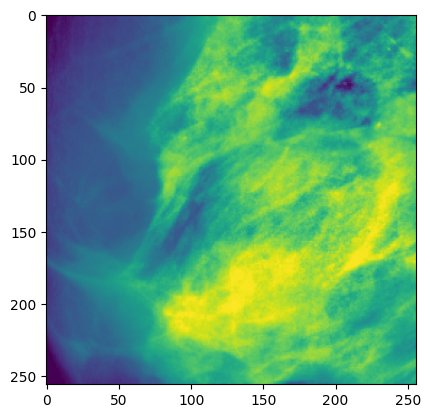

In [4]:
plt.imshow(next(iter(dataset.take(1)))[0])

In [5]:
train_ds = dataset.batch(batch_size)

In [6]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

11 9


In [8]:
# Create the discriminator.
discriminator = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer((image_size, image_size, discriminator_in_channels)),
        tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2D(512, (5, 5), strides=(1, 1), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2D(1024, (5, 5), strides=(1, 1), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.GlobalMaxPooling2D(),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

# Create the generator.
generator = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        tf.keras.layers.Dense(4 * 4 * generator_in_channels),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((4, 4, generator_in_channels)),
        tf.keras.layers.Conv2DTranspose(1024, (5, 5), strides=(2, 2), padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2DTranspose(32, (5, 5), padding="same"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(1, (5, 5), padding="same", activation="tanh"),
    ],
    name="generator",
)
discriminator.summary()
generator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      14464     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 128)       204928    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 256)       819456    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 32, 32, 256)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 512)     

In [9]:
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [10]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.999),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.999),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

In [11]:
cond_gan.fit(train_ds, epochs=15)

Epoch 1/15


2023-05-27 01:05:05.045895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/usr/local/lib/python3.8/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-05-27 01:05:07.517098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-27 01:05:08.208096: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.67GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if

2751/2751 [==============================] - 1194s 428ms/step - g_loss: 12.2278 - d_loss: 0.0122
Epoch 2/15
 681/2751 [======>.......................] - ETA: 14:26 - g_loss: 16.9596 - d_loss: 3.9525e-08

In [12]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator

trained_gen.save("trained_conditional_gan")

In [3]:
trained_gen = tf.keras.models.load_model("trained_conditional_gan")
trained_gen.compile()

2023-05-27 09:42:19.056069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-27 09:42:19.074307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-27 09:42:19.074507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-05-27 09:42:46.637196: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-27 09:42:47.900776: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-27 09:42:47.956104: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 [==============================] - 3s 3s/step


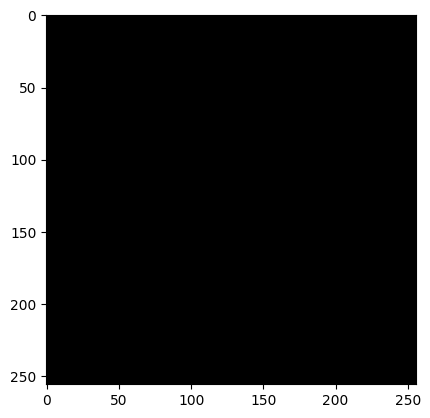

In [7]:
def generate_sample(label_ex):
    interpolation_noise = tf.random.normal(shape=(1, latent_dim))
    label = tf.keras.utils.to_categorical([label_ex], num_classes)
    label = tf.cast(label, tf.float32)
    noise_and_label = tf.concat([interpolation_noise, label], 1)
    fake = trained_gen.predict(noise_and_label)
    fake=fake*255
    fake=fake.astype(np.uint8)
    return fake*255

plt.imshow(generate_sample(0)[0], cmap="gray")